# Zipline Coding Exercises

In this notebook you will create your own pipeline and create custom factors and filters for it. 

### Install Packages

In [2]:
import sys
!{sys.executable} -m pip install -r requirements.txt

    100% |████████████████████████████████| 2.5MB 213kB/s eta 0:00:01
    100% |████████████████████████████████| 92kB 4.1MB/s eta 0:00:01
    100% |████████████████████████████████| 112kB 3.3MB/s eta 0:00:01
    100% |████████████████████████████████| 143kB 3.1MB/s eta 0:00:01   74% |███████████████████████▊        | 102kB 22.7MB/s eta 0:00:01
    100% |████████████████████████████████| 112kB 3.7MB/s eta 0:00:01
    100% |████████████████████████████████| 624kB 808kB/s eta 0:00:01
    100% |████████████████████████████████| 1.0MB 506kB/s eta 0:00:01
    100% |████████████████████████████████| 51kB 4.4MB/s eta 0:00:01
    100% |████████████████████████████████| 3.8MB 141kB/s eta 0:00:01    44% |██████████████▏                 | 1.7MB 25.0MB/s eta 0:00:01
    100% |████████████████████████████████| 102kB 4.8MB/s ta 0:00:01


  Running setup.py bdist_wheel for zipline ... done
  Stored in directory: /root/.cache/pip/wheels/a4/d6/67/f303ab028b004bf8e00c05b5b04fba83d8ec238b6547becdb7
  Running setup.py bdist_wheel for Logbook ... done
  Stored in directory: /root/.cache/pip/wheels/06/13/e9/88e9e8184d89671ffc754dc80f5eb01dabd72071bdb802c5d1
  Running setup.py bdist_wheel for cyordereddict ... done
  Stored in directory: /root/.cache/pip/wheels/0b/9d/8b/5bf3e22c1edd59b50f11bb19dec9dfcfe5a479fc7ace02b61f
  Running setup.py bdist_wheel for bottleneck ... done
  Stored in directory: /root/.cache/pip/wheels/f2/bf/ec/e0f39aa27001525ad455139ee57ec7d0776fe074dfd78c97e4
  Running setup.py bdist_wheel for bcolz ... done
  Stored in directory: /root/.cache/pip/wheels/c5/cc/1b/2cf1f88959af5d7f4d449b7fc6c9452d0ecbd86fd61a9ee376
  Running setup.py bdist_wheel for alembic ... done
  Stored in directory: /root/.cache/pip/wheels/57/58/91/31e495c790b05e82563181064a9670168d7eeb817e5595e3c3
  Running setup.py bdist_wheel for inte

# Load Data

In [3]:
import os

from zipline.data import bundles
from zipline.data.bundles.csvdir import csvdir_equities


# Specify the bundle name
bundle_name = 'm4-quiz-eod-quotemedia'

# Create an ingest function 
ingest_func = csvdir_equities(['daily'], bundle_name)

# Register the data bundle and its ingest function
bundles.register(bundle_name, ingest_func);

# Set environment variable 'ZIPLINE_ROOT' to the path where the most recent data is located
os.environ['ZIPLINE_ROOT'] = os.path.join(os.getcwd(), '..', '..', 'data', 'module_4_quizzes_eod')

# Load the data bundle
bundle_data = bundles.load(bundle_name)

# TODO: Build an Empty Pipeline with a Screen

In the code below create an empty with a screen that filters the pipeline output for stocks with a 60-day average dollar volume greater than \$50,000.

In [4]:
# import resources
from zipline.pipeline import Pipeline
from zipline.pipeline.factors import AverageDollarVolume

# Create a screen for our Pipeline
universe = AverageDollarVolume(window_length = 60)>50000

# Create an empty Pipeline with the given screen
pipeline = Pipeline(screen = universe)

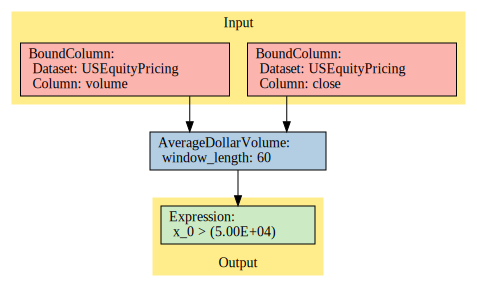

In [5]:
import graphviz

# Render the pipeline as a DAG
pipeline.show_graph()

# TODO: Create a Pipeline Engine

In the code below, create a data loader that loads our data bundle using Zipline's `USEquityPricingLoader`. Then create a function to be passed to the `get_loader` parameter in the pipeline engine. Using the NYSE trading calendar create a pipeline engine using Zipline's `SimplePipelineEngine`

In [6]:
# import resources
from zipline.pipeline.loaders import USEquityPricingLoader
from zipline.utils.calendars import get_calendar
from zipline.pipeline.data import USEquityPricing
from zipline.pipeline.engine import SimplePipelineEngine

# Set the dataloader
pricing_loader = USEquityPricingLoader(bundle_data.equity_daily_bar_reader, bundle_data.adjustment_reader)

# Define the function for the get_loader parameter
def choose_loader(column):
    if column not in USEquityPricing.columns:
        raise Exception('Column not in USEquityPricing')
    return pricing_loader

# Set the trading calendar
trading_calendar = get_calendar('NYSE')

# Create a Pipeline engine
engine = SimplePipelineEngine(get_loader = choose_loader,
                              calendar = trading_calendar.all_sessions,
                              asset_finder = bundle_data.asset_finder)

# TODO: Create Factors and Filters For The Pipeline

### Factors

In the code below, create two factors:

1. **Custom Factor**: Create a custom factor, `percent_difference`,  by combining a 30-day average closing price factor and a 60-average closing price factor. The `percent_difference` factor will calculate the difference between the 30-day and 60-average closing price factors, and will then normalize this difference by the 60-average closing price factor.


2. **Daily Returns Factor**: Create a factor that returns the daily percent change in closing price. To do this, use Zipline's built-in [DailyReturns](https://www.zipline.io/appendix.html#zipline.pipeline.factors.DailyReturns) factor.

Both factors should use the closing prices in the `USEquityPricing`  dataset as inputs. 




### Filters

In the code below, you will create a **Custom Filter**, `tradable_asset`, that returns `True` for the top 20 securities of average dollar volume in a 30 day-window that have a latest closing price above \$30. To do this, you will create two filters first and them combine them. For the first filter, you can use Zipline's built-in factor `AverageDollarVolume()` and its method `.top()` to select the top 20 assets of average dollar volume in a 30 day-window. To get the latest close price of the `USEquityPricing` dataset you can use `USEquityPricing.close.latest`. Finally you can combine these two filters by using the logical operator `&`. 

In [7]:
# import resources
from zipline.pipeline.factors import SimpleMovingAverage
from zipline.pipeline.factors import DailyReturns

# Create the 30-day average closing price factor
mean_close_30 = SimpleMovingAverage(inputs = [USEquityPricing.close], window_length = 30)

# Create the 60-day average closing price factor
mean_close_60 = SimpleMovingAverage(inputs = [USEquityPricing.close], window_length = 60)

# Create the custom factor
percent_difference = (mean_close_30 - mean_close_60) / mean_close_60

# Create the daily returns factor
daily_returns = DailyReturns(inputs = [USEquityPricing.close])

# Create a filter for the top 20 securities of average dollar volume in a 30 day-window
top20_securities = AverageDollarVolume(window_length = 30).top(20) 

# Create a filter for the latest closing price above $30
latest_filter = USEquityPricing.close.latest > 30

# Create a custum filter
tradable_asset = top20_securities & latest_filter

# TODO: Add Factors and Filters To The Pipeline

In the code below, add the factors and filters you created above to the pipeline

In [8]:
# Add the custom factor to the pipeline
pipeline.add(percent_difference, 'percentage difference')

# Add the daily returns factor to the pipeline
pipeline.add(daily_returns, 'daily returns')

# Add the custom filter to the pipeline
pipeline.add(tradable_asset, 'Custom Fileter')

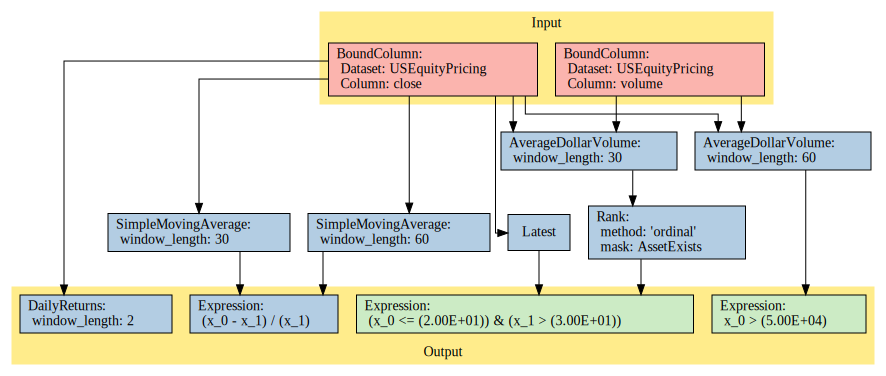

In [9]:
# Render the pipeline as a DAG
pipeline.show_graph()

# TODO: Run The Pipeline

In the code below, run the pipeline for the dates given

In [11]:
import pandas as pd
# Set starting and end dates
start_date = pd.Timestamp('2014-01-06', tz='utc')
end_date = pd.Timestamp('2016-01-05', tz='utc')

# Run our pipeline for the given start and end dates
output = engine.run_pipeline(pipeline, start_date, end_date)

# Display the pipeline output
output.head()

Custom Fileter  daily returns  \
2014-01-06 00:00:00+00:00 Equity(0 [A])              False       0.006951   
                          Equity(1 [AAL])            False       0.046523   
                          Equity(2 [AAP])            False       0.028611   
                          Equity(3 [AAPL])            True      -0.021972   
                          Equity(4 [ABBV])           False       0.006147   

                                            percentage difference  
2014-01-06 00:00:00+00:00 Equity(0 [A])                  0.025939  
                          Equity(1 [AAL])                0.055887  
                          Equity(2 [AAP])                0.051009  
                          Equity(3 [AAPL])               0.035906  
                          Equity(4 [ABBV])               0.033018

In [1]:
!tar chvzf notebook.tar.gz --exclude notebook.tar.gz *

requirements.txt
zipline_coding_exercises.ipynb
zipline_coding_exercises_solution.ipynb


## Solution

[Solution notebook](zipline_coding_exercises_solution.ipynb)